# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import time

In [2]:
taxi = pd.read_csv("/datasets/taxi.csv",index_col=[0], parse_dates=[0])
taxi.sort_index(inplace=True)
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# Resample the data by one hour
taxi = taxi.resample('1H').sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<span style=color:blue> Comments: In the first section, I simply downloaded the dataset into a dataframe called taxi but I made sure to convert the datetime column as the dataframe index. This way the number of colums is only 1 (num_orders) and the datetime column is the index. I used the info method to check this was done correctly and see there is 26,496 entries as well as verify the data type. Next I used .head() to just view some of the dataset. Then I resampled the data using .resample by One Hour, as per the instructions. I ran .head() again to verify.

## Analysis

In [5]:
# Check for duplicates
taxi.index.duplicated().sum()

0

In [6]:
# Check for null values
taxi.isnull().sum()

num_orders    0
dtype: int64

In [7]:
taxi.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


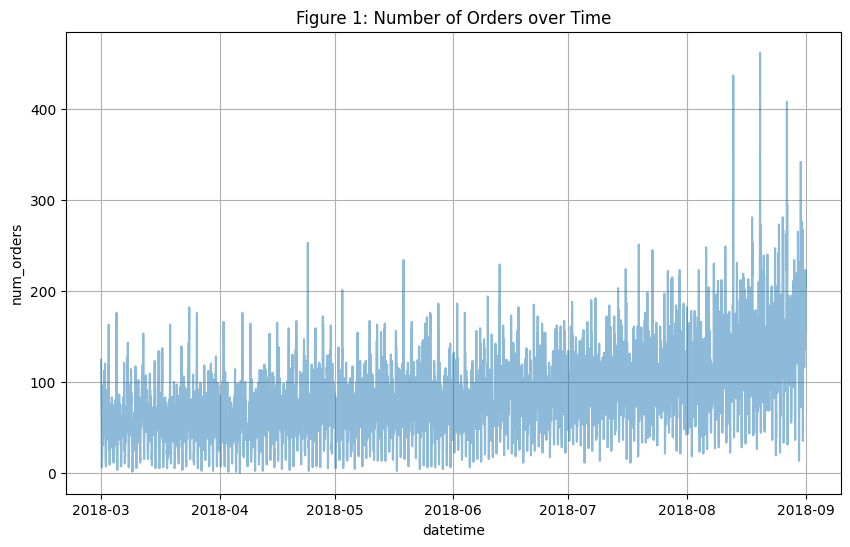

In [8]:
# Let's view the data by graphical representation
plt.figure(figsize=(10, 6))
plt.plot(taxi['num_orders'], alpha = 0.5)
plt.title('Figure 1: Number of Orders over Time')
plt.xlabel('datetime')
plt.ylabel('num_orders')
plt.grid(True)
plt.show()

<span style = color:blue> Comments: In this section, I checked the resampled dataset for duplicates on the index since that should not have any repeats, whereas the num_orders column can have repeats. I also verified there were no NA values and then I plotted the dataset as num_orders over time. This graph shows all the data points per hour from 03-2018 to 09-2018. From the graph we can immediately see there is an upwards curve as we move forward in time. Especially closer to the 08 and 09 months, we see the average of the points is higher than that of months 03 and 04. This will be useful information later as it indicated non-stationary behavior. For now, I did not analyze the graph any further and decided to move on to the model training section.

## Training

In [9]:
# Let's start by creating useful Time-Based Features from the index
taxi['year'] = taxi.index.year
taxi['month'] = taxi.index.month
taxi['day'] = taxi.index.day
taxi['hour'] = taxi.index.hour

# Add in the Lag components
taxi['lag_1h'] = taxi['num_orders'].shift(1)
taxi['lag_24h'] = taxi['num_orders'].shift(24)
taxi['lag_168h'] = taxi['num_orders'].shift(168)

taxi.head()

,num_orders,year,month,day,hour,lag_1h,lag_24h,lag_168h
datetime,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,2,85.0,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,4,66.0,NaN,NaN


In [10]:
# Drop all Na Values
taxi.dropna(inplace=True)
taxi.isna().sum()

num_orders    0
year          0
month         0
day           0
hour          0
lag_1h        0
lag_24h       0
lag_168h      0
dtype: int64

In [11]:
# Split the data into feature and target
X = taxi.drop(columns=['num_orders'],axis=1)
y = taxi['num_orders']

X.columns

Index(['year', 'month', 'day', 'hour', 'lag_1h', 'lag_24h', 'lag_168h'], dtype='object')

In [12]:
# Split the data into train and temp subsets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.2, shuffle = False, random_state=123)

# Split the temp set into validation and test subsets with 10% for each
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, shuffle=False, random_state = 123)
print(X.shape, X_val.shape, X_test.shape)

(4248, 7) (425, 7) (425, 7)


In [13]:
# Let's Train our Machine Learning Models
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(max_depth=15, random_state=123),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=123),
    'LightGBM': LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=15, random_state=123),
    'CatBoostRegressor': CatBoostRegressor(n_estimators=200, learning_rate=0.05, depth=10, verbose=0, random_state=123)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    results.append({
        'model': name,
        'RMSE': rmse.round(2)})

rmse_results = pd.DataFrame(results)
print(rmse_results.sort_values('RMSE'))

               model   RMSE
0   LinearRegression  31.49
2       RandomForest  32.68
4  CatBoostRegressor  32.70
3           LightGBM  33.67
1       DecisionTree  41.53


In [14]:
# Let's train our Time Series Models
# AutoRegressive (AR) Model
start_value = len(y_train)
end_value = len(y_train) + len(y_val) - 1

best_lag = 0
best_rmse = 100
lags = [6,12,24,30]

for lag in lags:
    ar_model = AutoReg(y_train, lags=lag).fit()
    y_pred_ar = ar_model.predict(start=start_value, end=end_value)
    rmse_ar = mean_squared_error(y_val, y_pred_ar, squared = False)
    print(f"Lags = {lag} | RMSE = {rmse_ar:.2f}")

    if rmse_ar < best_rmse:
        best_rmse = rmse_ar
        best_lag = lag
print()
print(f"Best Lag = {best_lag} | Best AR RMSE = {best_rmse:.2f}")

results.append({'model': 'AutoReg','RMSE': best_rmse.round(2)})

Lags = 6 | RMSE = 58.50
Lags = 12 | RMSE = 57.90
Lags = 24 | RMSE = 50.62
Lags = 30 | RMSE = 53.14

Best Lag = 24 | Best AR RMSE = 50.62


In [15]:
# Moving Average (MA) Model
ma_model = ARIMA(y_train, order=(0, 0, 1)).fit()
y_pred_ma = ma_model.predict(start=start_value, end=end_value)
rmse_ma = mean_squared_error(y_val,y_pred_ma, squared = False)
print(f"RMSE for MA Model = {rmse_ma:.2f}")

results.append({'model': 'MovingAvg','RMSE': rmse_ma.round(2)})

RMSE for MA Model = 58.66


In [16]:
# ARIMA Model
arima_model = ARIMA(y_train, order=(1,0,1)).fit()
y_pred_arima = arima_model.predict(start=start_value, end=end_value)
rmse_arima = mean_squared_error(y_val, y_pred_arima, squared = False)
print(f"RMSE for ARIMA Model = {rmse_arima:.2f}")

results.append({'model': 'ARIMA','RMSE': rmse_arima.round(2)})

RMSE for ARIMA Model = 58.57


In [17]:
# Let's put ethe RMSE values for every model into 1 dataframe
rmse_results = pd.DataFrame(results)
print(rmse_results.sort_values('RMSE'))

               model   RMSE
0   LinearRegression  31.49
2       RandomForest  32.68
4  CatBoostRegressor  32.70
3           LightGBM  33.67
1       DecisionTree  41.53
5            AutoReg  50.62
7              ARIMA  58.57
6          MovingAvg  58.66


<div>
    <span style=color:blue> Comments: For this part of the project, I trained many different models on the training dataset and made predictions on the validation datasets. I calculated the RMSE values for each model and compared them all together in one rmse_results dataframe. After sorting by RMSE value, we can see that Linear Regression ranks as the lowest RMSE value of all the models. 
        
Additionally, we see that the Time-Based models of AR, MA and ARIMA rank amongst the lowest with RMSE values of 50+, which puts all three over the limit of 48 as per the project requirements. There could be several reasons for this such as overfitting on the ML models and lack of hypertuning parameters on the time based models. However, seeing that several ML models were used here and all of them passed the criteria, the issue might be with the time based models here. 

For my AutoReg model, I created a for loop to find the best lag and we see 24 has the lowest rmse, however it was too high. I could increase the lag much higher but it makes the model more complex and creates a much longer runtime. For MA and ARIMA models, I tested different values for the order=(p,d,q) parameter and choose the values with the lowest RMSE. I used ARIMA over ARMA because we see in the graphical representation earlier that there is a slight curve in the data which means it is probably more non-stationary than stationary. As such we should use the ARIMA model over the ARMA model here. Lastly, I did not use SARIMA model since I do not observe any seasonality within the dataset.

In conclusion, I chose LinearRegression model to test on the data on the test sample as it provided the least RMSE value and is generally very fast on runtime.

## Testing

In [18]:
# Let's test on the test set using Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_test = lr_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared = False)
print(f"RMSE on Test Set using LR Model = {rmse_test:.2f}")

RMSE on Test Set using LR Model = 35.62


<div span style=color:blue>  Comments - Conclusions:

This was a great project overall because it brought together all the previous learnings of Machine Learning Models and blended it with the new learnings of Time Based models. I understand the idea of time-series a lot more due to this project. The project objective was straightforward in training models, comparing based on RMSE values and testing the best one on a test set. I believe I did everything as per the project requirements, please let me know if anything was done incorrectly or is missing from my work.

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48